# Generate synthetic data
Generating synthetic data using public libraries for the 'adult' dataset.

## Load libraries and define settings

In [1]:
# general dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

In [2]:
# package
from crnsynth2.generators.marginal_generator import MarginalGenerator
from crnsynth2.generators.privbayes import PrivBayes

In [3]:
# data-specific
from examples.adult.adult_config import PATH_ADULT, PATH_RESULTS
from examples.adult.adult_synthpipe import AdultSynthPipe


In [4]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

In [5]:
# privacy budget for differentially private algorithms
EPSILON = 1

# dataset
DATASET_NAME = 'adult'

# other
RANDOM_STATE = 42

## Load and process dataset

In [6]:
df_adult = pd.read_csv(PATH_ADULT)
df_adult.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Generate
Here we show how step by step how to generate synthetic data.

In [7]:
# define your generator - in this case the simple marginal generator
generator = MarginalGenerator(epsilon=EPSILON)

# train the generator on the input data
generator.fit(df_adult)

# generate synthetic data with a desired number of rows
df_synth_marginal = generator.generate(n_records=1000)
df_synth_marginal.head()

Marginal fitted: age
Marginal fitted: workclass
Marginal fitted: fnlwgt
Marginal fitted: education
Marginal fitted: education-num
Marginal fitted: marital-status
Marginal fitted: occupation
Marginal fitted: relationship
Marginal fitted: race
Marginal fitted: sex
Marginal fitted: capital-gain
Marginal fitted: capital-loss
Marginal fitted: hours-per-week
Marginal fitted: native-country
Marginal fitted: income
Column sampled: age
Column sampled: workclass
Column sampled: fnlwgt
Column sampled: education
Column sampled: education-num
Column sampled: marital-status
Column sampled: occupation
Column sampled: relationship
Column sampled: race
Column sampled: sex
Column sampled: capital-gain
Column sampled: capital-loss
Column sampled: hours-per-week
Column sampled: native-country
Column sampled: income


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,47,Private,339755,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,44,South,<=50K
1,39,Self-emp-not-inc,62176,Some-college,10,Never-married,Craft-repair,Husband,Black,Male,7430,0,26,?,>50K
2,44,Private,54159,Bachelors,14,Never-married,Craft-repair,Not-in-family,White,Female,7688,2205,20,United-States,>50K
3,31,Local-gov,110331,HS-grad,9,Never-married,Handlers-cleaners,Husband,White,Male,0,0,35,United-States,<=50K
4,25,Private,317681,HS-grad,13,Widowed,Exec-managerial,Not-in-family,White,Male,0,0,50,United-States,>50K


## Synth Pipeline

More often than not, you will need to some extra processing steps to improve the quality of the synthetic data - similar to training a machine learning model. These steps can be put in a pipeline, consisting of the following steps:
1. pre-processing: process the original data by removing or altering information you do not want to capture in the synthetic dataset, e.g. sensitive information or incorrect values.
2. fit: train the generator algorithm on the processed data
3. generate: generate a desired number of samples
4. post-process: post-process the synthetic data to remove inconsistencies or add additional information to the synthetic dataset

We defined a pipeline for the adult dataset. If you're curious on how to define such pipelines yourself, look at the code in `examples/adult/adult_synthpipe.py`

In [8]:
# create copy to retain original data format
df = df_adult.copy()

# create a synthetic pipeline
generator=PrivBayes(epsilon=0.1)
synth_pipe = AdultSynthPipe(generator=generator, holdout_size=0.2, target_column='income', random_state=RANDOM_STATE)

data_out = synth_pipe.run(df, n_records=1000)
data_out['synth'].head()


Epsilon generalizers: 0.1
Epsilon generator: 0.1
Total epsilon: 0.2

1/11 - Root of network: income

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'marital-status' - with parents: ('income',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'age' - with parents: ('income',)

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 9
Selected attribute: 'relationship' - with parents: ('income',)

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 9
Selected attribute: 'education' - with parents: None

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 8
Selected attribute: 'sex' - with parents: ('relationship',)

7/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 6
Selected attribute: 'nativ

IndexError: index 5 is out of bounds for axis 0 with size 5

## Generalization

In [20]:
df.loc[51]

age                          18
workclass               Private
fnlwgt                   226956
education               HS-grad
education-num                 9
marital-status    Never-married
occupation        Other-service
relationship          Own-child
race                      White
sex                      Female
capital-gain                  0
capital-loss                  0
hours-per-week               30
native-country                ?
income                    <=50K
Name: 51, dtype: object

In [25]:
from crnsynth2.process.generalize_mech import NumericGeneralizationMech

num_gen_mech = NumericGeneralizationMech(column='age', epsilon=0.1, bins=10, bounds=(18, 90), inverse='truncated_normal', ignore_nan=True, random_state=RANDOM_STATE)
df_gen = num_gen_mech.fit_transform(df)
df_gen

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,3,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,5,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,3,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,5,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,2,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,2,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,3,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,6,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,1,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [26]:
df_gen[df_gen.age == 0]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [27]:
df_gen.age.value_counts().sort_index()

1     6411
2     6752
3     6763
4     5573
5     3697
6     2207
7      821
8      258
9       36
10      43
Name: age, dtype: int64

In [28]:
num_gen_mech.bin_edges_

array([18., 26., 34., 42., 50., 58., 66., 74., 82., 90.])

In [29]:
df_inv = num_gen_mech.inverse_transform(df_gen)

IndexError: index 10 is out of bounds for axis 0 with size 10

<Axes: >

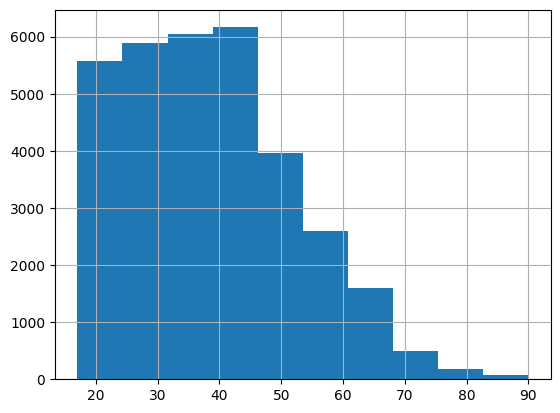

In [51]:
df.age.hist()

<Axes: >

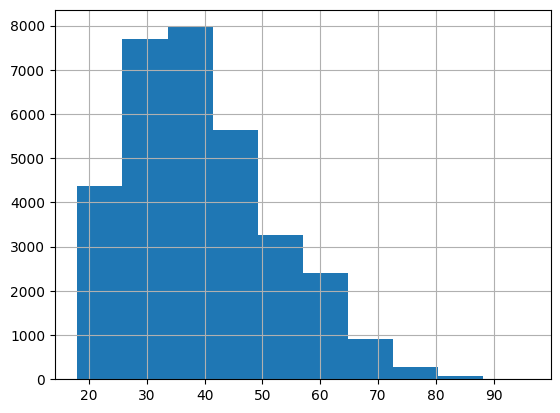

In [52]:
df_inv.age.hist()

## Experiment
Run multiple synthesis experiments

In [84]:
from crnsynth2.experiment.experiment import SynthExperiment
from crnsynth2.metrics import DEFAULT_METRICS, PRIVACY_METRICS
from crnsynth2.experiment import utils

In [17]:
from sklearn.model_selection import ParameterGrid

pg = ParameterGrid(param_grid=param_grid)
for p in pg:
    print(p)


{'epsilon': 0.01, 'holdout_size': 0.2}
{'epsilon': 0.01, 'holdout_size': 0.3}
{'epsilon': 0.01, 'holdout_size': 0.4}
{'epsilon': 0.1, 'holdout_size': 0.2}
{'epsilon': 0.1, 'holdout_size': 0.3}
{'epsilon': 0.1, 'holdout_size': 0.4}
{'epsilon': 1, 'holdout_size': 0.2}
{'epsilon': 1, 'holdout_size': 0.3}
{'epsilon': 1, 'holdout_size': 0.4}


In [86]:
# def create_synthpipes(default_pipeline, generators):
#     synthpipes = [default_pipeline.__copy__().set_generator(generator) for generator in generators]
#     return synthpipes

# create synthpipes
default_pipe = AdultSynthPipe(holdout_size=0.2, random_state=RANDOM_STATE)
generators = [PrivBayes(epsilon=1), MarginalGenerator(epsilon=1)]

param_grid = {
    'epsilon': [0.01, 0.1,],
    'holdout_size': [0.2, 0.3]
}

synth_pipes = utils.init_synthpipes(default_pipe, generators, param_grid=param_grid)
synth_pipes

[AdultSynthPipe({'generator': PrivBayes({'epsilon': 0.1, 'verbose': True, 'theta_usefulness': 4, 'epsilon_split': 0.3, 'score_function': 'R', 'network_init': None, 'n_cpus': None}), 'holdout_size': 0.3, 'target_column': None, 'random_state': 42, 'verbose': 2, 'generalize': True, 'dp_params': [DPParam(stat_name=mean, epsilon=0.025, column=age), DPParam(stat_name=std, epsilon=0.025, column=age), DPParam(stat_name=mean, epsilon=0.025, column=hours-per-week), DPParam(stat_name=std, epsilon=0.025, column=hours-per-week)]}),
 AdultSynthPipe({'generator': PrivBayes({'epsilon': 0.1, 'verbose': True, 'theta_usefulness': 4, 'epsilon_split': 0.3, 'score_function': 'R', 'network_init': None, 'n_cpus': None}), 'holdout_size': 0.3, 'target_column': None, 'random_state': 42, 'verbose': 2, 'generalize': True, 'dp_params': [DPParam(stat_name=mean, epsilon=0.025, column=age), DPParam(stat_name=std, epsilon=0.025, column=age), DPParam(stat_name=mean, epsilon=0.025, column=hours-per-week), DPParam(stat_na

In [99]:
new_pipe = default_pipe.__copy__()
new_pipe.set_params(params={'holdout_size': 0.4})
new_pipe

AdultSynthPipe({'generator': None, 'holdout_size': 0.2, 'target_column': None, 'random_state': 42, 'verbose': 2, 'generalize': True, 'dp_params': [DPParam(stat_name=mean, epsilon=0.025, column=age), DPParam(stat_name=std, epsilon=0.025, column=age), DPParam(stat_name=mean, epsilon=0.025, column=hours-per-week), DPParam(stat_name=std, epsilon=0.025, column=hours-per-week)]})

In [11]:
PRIVACY_METRICS

[DistanceClosestRecord({'quantile': 0.5, 'metric': 'gower', 'categorical_columns': None}),
 NearestNeighborDistanceRatio({'quantile': 0.5, 'metric': 'gower', 'n_neighbors': 5, 'categorical_columns': None})]

In [12]:
synth_experiment = SynthExperiment(experiment_name='adult_synthesis', synth_pipes=synth_pipes, metrics=PRIVACY_METRICS, path_out=PATH_RESULTS)
synth_experiment.run(df_adult, n_records=1000)

Running synthesis experiment for PrivBayes
Computing DP parameter mean on column age
Computing DP parameter std on column age
Computing DP parameter mean on column hours-per-week
Computing DP parameter std on column hours-per-week

Epsilon params: 0.1
Epsilon generator: 1
Total epsilon: 1.1

1/11 - Root of network: income

2/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 10
Selected attribute: 'relationship' - with parents: ('income',)

3/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 9
Selected attribute: 'marital-status' - with parents: ('relationship', 'income')

4/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 15


/Users/dknoors/Projects/synthesis-dk/synthetic-data-generation/synthesis/transformers/generalization.py:53: UserWarning: Bins whose width are too small (i.e., <= 1e-8). Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Selected attribute: 'sex' - with parents: ('marital-status', 'relationship', 'income')

5/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 21
Selected attribute: 'age' - with parents: ('marital-status', 'sex', 'income')

6/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 29
Selected attribute: 'occupation' - with parents: ('sex', 'income')

7/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 28
Selected attribute: 'workclass' - with parents: ('occupation',)

8/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 26
Selected attribute: 'hours-per-week' - with parents: ('income', 'occupation')

9/11 - Evaluating next attribute to add to network
Number of AttributeParentPair candidates: 25
Selected attribute: 'education' - with parents: ('income', 'age')

10/11 - Evaluating next attribute to add to network
Number of AttributePar

/Users/dknoors/miniconda3/envs/crnsynth/lib/python3.9/site-packages/thomas/core/factors/cpt.py:65: RuntimeWarning: invalid value encountered in divide
  self.values = self.values / row_sum


Number of records generated: 1000 / 1000
Synthetic Data Generated


ValueError: could not convert string to float: 'Private'